<a href="https://colab.research.google.com/github/langfordzd/bursts-cc-pt/blob/main/parameter_picks.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# First we need to install and import a few things



In [3]:
!pip install neurodsp
!pip install bycycle

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [4]:
import matplotlib.pyplot as plt
import numpy as np
from bycycle.features import compute_features
from neurodsp.sim import sim_powerlaw
from neurodsp.utils import set_random_seed
import itertools
from multiprocessing import Pool, cpu_count      
import pandas as pd
import seaborn as sns

In [6]:
def f_cf(signal,thresh):
    
    threshold_kwargs = {'amp_fraction_threshold': 0.0, 
                   'amp_consistency_threshold': thresh[0],
                   'period_consistency_threshold': thresh[1],
                   'monotonicity_threshold': thresh[2],
                   'min_n_cycles': thresh[3]}
    
    sf = compute_features(signal[1], s_rate, 
                              (15,29), threshold_kwargs=threshold_kwargs,
                              return_samples=True)
    count = 0
    bursts = sf[sf['is_burst']]         
    if any(bursts['is_burst']):
        burst_list = np.split(bursts, np.flatnonzero(np.diff(bursts.index) != 1) + 1)
        count = len(burst_list)
        
    return count

In [10]:
#%% THIS WILL TAKE A LONG TIME
set_random_seed(1)
n_noises = 1000
secs = 1
s_rate = 250
threshs = np.around(np.arange(0.2,0.8+0.1,0.2),3).tolist()
wte = list(itertools.product(threshs, repeat= 3))   
wte2 = [e + tuple([2]) for e in wte]
wte3 = [e + tuple([3]) for e in wte]
wte = wte2+wte3
signals = [(i,sim_powerlaw(secs, s_rate, exponent=-2)) for i in range(0,n_noises)]
sig_eval_product = list(itertools.product(signals, wte))
num_cores = cpu_count()
pool = Pool(processes=num_cores)
result =  pool.starmap(f_cf, sig_eval_product)
pool.close()
pool.join()  

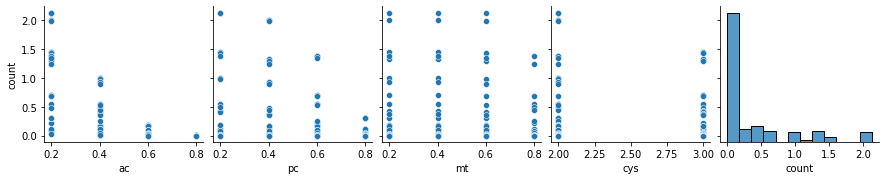

In [11]:
wte_map = [x[1] for x in sig_eval_product]
num_map = [x[0][0] for x in sig_eval_product]
answer = [tuple([b])+e for b,e in zip(result,wte_map)]
t = pd.DataFrame(answer,columns=['count', 'ac', 'pc', 'mt','cys'])
t['noise'] = num_map
rands = 1000 #times to randomize
exp_size = 100 #trials
ss = []
import random
for _ in range(rands):
    rs = random.sample(range(0, n_noises), exp_size)
    selec = t.loc[t['noise'].isin(rs)]
    ss_ = pd.DataFrame(selec.groupby(['ac', 'pc', 'mt','cys'],as_index=False)['count'].mean())
    ss.append(ss_)

t = pd.concat(ss)
a = pd.DataFrame(t.groupby(['ac', 'pc', 'mt','cys'],as_index=False)['count'].mean())
sns.pairplot(a, y_vars="count", x_vars=a.columns.values)

No handles with labels found to put in legend.


Text(0.5, 0, 'mt')

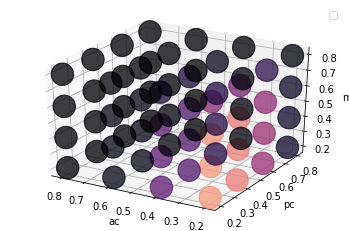

In [26]:

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
sc = ax.scatter(a.ac, a.pc, a.mt, s=500, c=np.array(a['count']), cmap='magma',marker='o',alpha=0.5)
ax.invert_yaxis()
ax.legend()
ax.set_xlabel('ac')
ax.set_ylabel('pc')
ax.set_zlabel('mt')

In [28]:
import plotly.express as pex

my_plot = pex.scatter_3d(a, x='ac',y='pc',z='mt',color='count')
my_plot.show()